# Experiment 2

In this experiment, we moved joint 0 over a span of around 160° and try to predict the joint angle with different models. \
For results, see folder model-comparison.

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns

In [2]:
labels = pd.read_csv("./data/samples.csv", dtype={"notes":"str"})

In [3]:
labels

,idx,q_0,q_1,q_2,q_3,q_4,q_5,q_6,q_7,samples,SR,session_id,notes
0,0,0.883266,-0.043772,-0.116724,-1.767878,-0.042979,1.811221,0.039998,0.0,80896,16000,0,
1,1,0.728893,-0.042582,-0.118711,-1.768172,-0.042987,1.811217,0.039660,0.0,80896,16000,0,
2,2,0.553810,-0.041615,-0.103017,-1.768377,-0.043015,1.811211,0.039652,0.0,80896,16000,0,
3,3,0.410330,-0.038282,-0.095798,-1.768288,-0.043018,1.811259,0.038886,0.0,80896,16000,0,
4,4,0.168166,-0.039483,-0.098186,-1.767707,-0.043345,1.811258,0.040031,0.0,80896,16000,0,
...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,235,0.376543,0.007160,0.012730,-1.575005,-0.021305,1.526497,-0.010171,0.0,80896,16000,26,
236,236,0.428531,0.007172,0.016851,-1.575011,-0.021303,1.526497,-0.010178,0.0,80896,16000,26,
237,237,0.489110,0.007395,0.017158,-1.575696,-0.021301,1.526481,-0.010175,0.0,80896,16000,26,
238,238,0.568463,0.010755,0.025522,-1.577284,-0.021286,1.526464,-0.010178,0.0,80896,16000,26,


In [4]:
labels.describe()

,idx,q_0,q_1,q_2,q_3,q_4,q_5,q_6,q_7,samples,SR,session_id
count,240.00000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.0,240.0,240.0,240.000000
mean,119.50000,-0.086807,-0.004176,0.031224,-1.612658,-0.035257,1.623447,0.028667,0.0,80896.0,16000.0,12.650000
std,69.42622,0.497664,0.018307,0.074023,0.066449,0.009253,0.105278,0.075707,0.0,0.0,0.0,8.038766
min,0.00000,-1.168625,-0.054549,-0.118711,-1.768377,-0.043390,1.512423,-0.029882,0.0,80896.0,16000.0,0.000000
25%,59.75000,-0.488478,-0.014200,0.000196,-1.654916,-0.042196,1.526472,-0.013382,0.0,80896.0,16000.0,5.750000
50%,119.50000,-0.070474,0.001240,0.003440,-1.574925,-0.040543,1.548387,-0.009352,0.0,80896.0,16000.0,13.000000
75%,179.25000,0.326199,0.007150,0.018959,-1.561053,-0.021722,1.688391,0.066044,0.0,80896.0,16000.0,20.000000
max,239.00000,0.883266,0.038515,0.191562,-1.540088,-0.020854,1.813069,0.324908,0.0,80896.0,16000.0,26.000000


(-75.0, 75.0)

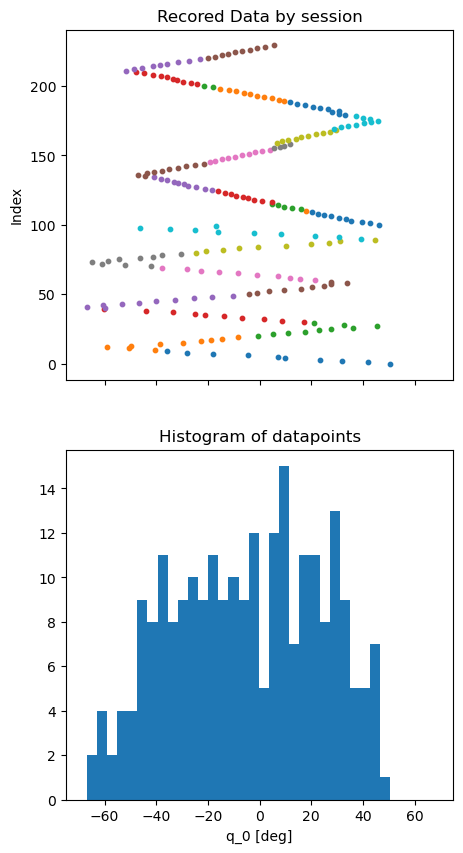

In [5]:
fig, axs = plt.subplots(2, sharex=True, figsize=(5,10))

for sess in range(np.max(labels.session_id)):
    session  = labels[labels.session_id==sess]
    axs[0].scatter(np.rad2deg(session.q_0), session.idx, s=10)

axs[0].set_title("Recored Data by session")
axs[0].set_ylabel("Index")

axs[1].hist(np.rad2deg(labels.q_0), bins=30)
axs[1].set_title("Histogram of datapoints")
axs[1].set_xlabel("q_0 [deg]")
plt.xlim((-75,75))

In [7]:
labels.iloc[0].q_0

np.float64(0.8832664489746094)

In [6]:
import scipy.io.wavfile
import os

inputpath = "./data" 
inputlength =  5
SR = 16000
outputlength = 4096//2
applyFFT = True

inputfiles = os.listdir(inputpath)

split_into = (inputlength * SR // outputlength)
output_datapoints = len(inputfiles) * split_into
req_inputlength = split_into * outputlength

# X_long = np.zeros((0,80896))

print(f"Splitting each input into {split_into} datapoints, resulting in {output_datapoints} samples")

X = np.zeros((output_datapoints, outputlength))
y = np.full((output_datapoints, 2), np.nan)

for i, file in enumerate(inputfiles):
    if file.split(".")[1] != "wav":
        continue
    sr, data = scipy.io.wavfile.read(inputpath + "/" + file)
    idx = int(file.split(".")[0])
    if sr != SR:
        raise(f"Samplerate of {file} is {sr} instead of {SR}")
    
    if len(data) < req_inputlength:
        raise(f"File {file} is not long enough")

    # X_long = np.vstack((X_long, data[:,0]))
    
    start_of_block = (len(data) - req_inputlength) // 2
    data_block = data[start_of_block:start_of_block+req_inputlength, 1]
    X[i*split_into:(i+1)*split_into, :] = data_block.reshape((split_into, outputlength))
    y[i*split_into:(i+1)*split_into, :] = np.array((idx, labels.iloc[idx].q_0))

if applyFFT:
    # TODO Hamming (or other) window?
    print("applying FFT")
    X = np.abs(np.fft.rfft(X))

Splitting each input into 39 datapoints, resulting in 9438 samples
applying FFT


In [19]:
np.log(len(np.unique(X_long)))

np.float64(10.073441275336219)

In [20]:
X_long_normed = X_long / np.max(np.abs(X_long))

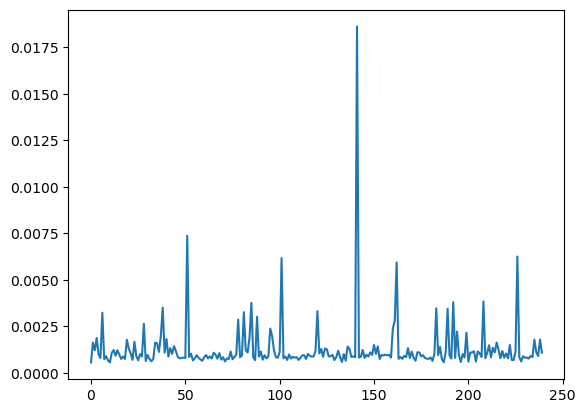

In [21]:
plt.plot(np.average(X_long_normed**2, axis=1))

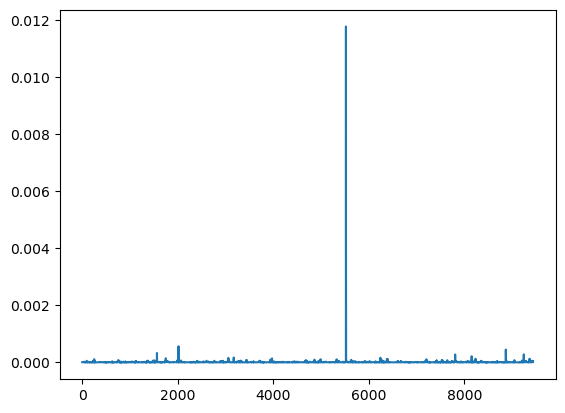

In [15]:
plt.plot(np.average((X/np.max(np.abs(X)))**2, axis=1))

In [7]:
np.argmax(np.average(X_long_normed**2, axis=1))

NameError: name 'X_long_normed' is not defined

[Text(0.5, 0, 'frequency')]

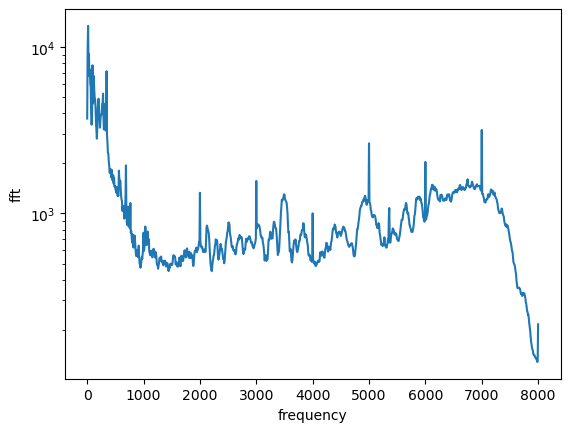

In [8]:
sample_rate = 16000
freq = np.fft.rfftfreq(outputlength, d=1./sample_rate)


plt.plot(freq, np.average(X, axis=0))

plt.yscale("log")
plt.ylabel("fft")
plt.gca().set(xlabel="frequency")

In [9]:
rng = np.random.default_rng(0)
train_fraction = 0.7
train_idx = rng.choice(np.arange(len(labels)), int(len(labels)*train_fraction), replace=False)
train_samples = int(train_fraction*len(X))

X_train = np.zeros((0, X.shape[1]))
X_test = np.zeros((0, X.shape[1]))
y_train = np.zeros((0,))
y_test = np.zeros((0, ))
for idx in range(len(labels)):
    indizes = y[:,0] == idx
    if idx in train_idx:
        X_train = np.vstack((X_train, X[indizes]))
        y_train = np.hstack((y_train, y[indizes,1]))
    else:
        X_test = np.vstack((X_test, X[indizes]))
        y_test = np.hstack((y_test, y[indizes,1]))


In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
X_scaled = StandardScaler().fit_transform(X)
X_decomp = PCA(n_components=2).fit_transform(X_scaled)

(-10.0, 15.0)

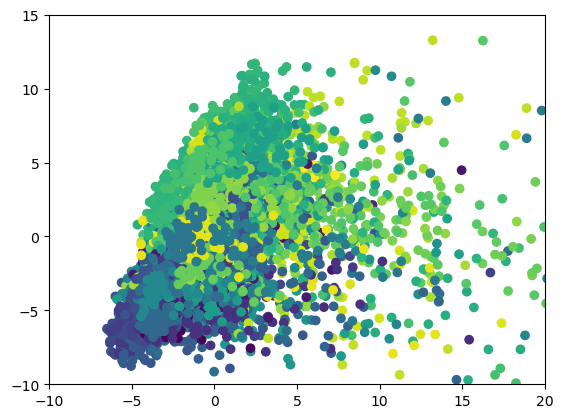

In [11]:
plt.scatter(X_decomp[:,0], X_decomp[:,1], c=y[:,1])
plt.xlim((-10,20))
plt.ylim((-10,15))

In [12]:
ynorm = np.max(np.abs(y)) + 0.01

def nonlinear_projection_head(z):
    return (1/(1+np.exp(-z))*2 - 1) * ynorm

def nonlinear_projection_head_inv(y_true):
    normed_y = (y_true / ynorm)/2 + 0.5
    return np.log(normed_y/(1-normed_y))

In [13]:
np.allclose(y, nonlinear_projection_head(nonlinear_projection_head_inv(y)))

False

In [14]:
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline


clf = make_pipeline(StandardScaler(), LinearRegression())
clf.fit(X_train, y_train)
clf.score(X_train, y_train)

0.8998269368263854

In [15]:
clf.score(X_test, y_test)

0.7751613149321144

[Text(0.5, 0, 'Ground Truth [deg]'),
 Text(0, 0.5, 'Predicted Angle [deg]'),
 Text(0.5, 1.0, 'Linear Regression Predictions')]

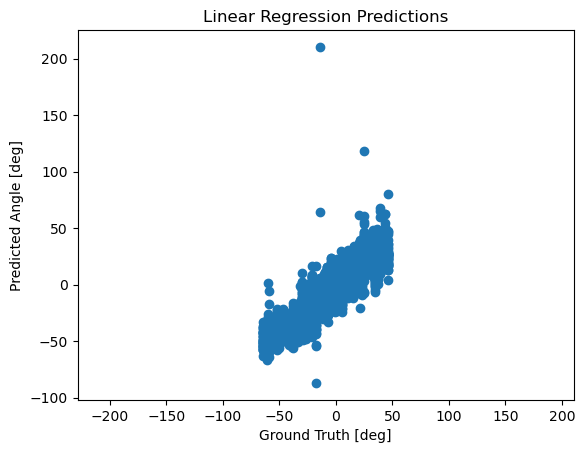

In [16]:
deg_preds = np.rad2deg(clf.predict(X_test))
plt.scatter(np.rad2deg((y_test)), deg_preds)
plt.axis("equal")
plt.gca().set(xlabel="Ground Truth [deg]", ylabel="Predicted Angle [deg]", title="Linear Regression Predictions")

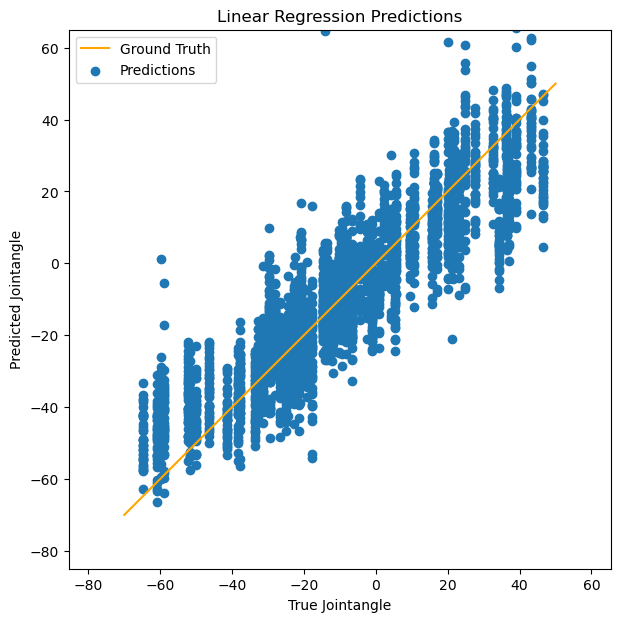

In [17]:
deg_preds = np.rad2deg(clf.predict(X_test))
plt.figure(figsize=(7,7))
plt.plot((-70,50), (-70,50), c="orange", label="Ground Truth")
plt.scatter(np.rad2deg((y_test)), deg_preds, label="Predictions")
plt.axis("equal")
plt.ylim((-85,65))
plt.gca().set(xlabel = "True Jointangle")
plt.ylabel("Predicted Jointangle")
plt.title("Linear Regression Predictions")
plt.legend()

In [18]:
deviation = np.sqrt(np.sum((deg_preds-np.rad2deg(y_test))**2)/len(y_test))

In [19]:
print(deviation)

13.124949043053293


In [20]:
def make_errorbar_plot(y_true, y_pred):
    y_pred = y_pred.reshape(-1, split_into)
    x = y_true[::split_into]
    avg = np.average(y_pred, axis=1)
    std = np.std(y_pred, axis=1)

    plt.figure(figsize=(7,7))
    plt.plot((-70,50), (-70,50), c="orange", label="ground truth")
    plt.errorbar(x, avg, std,fmt='o', label="predicted values")
    plt.axis("equal")
    plt.ylim((-60,40))
    plt.xlabel("True Jointangle")
    plt.ylabel("Predicted Jointangle")
    plt.title("Average of the Linear Regression Predictions")
    plt.legend()

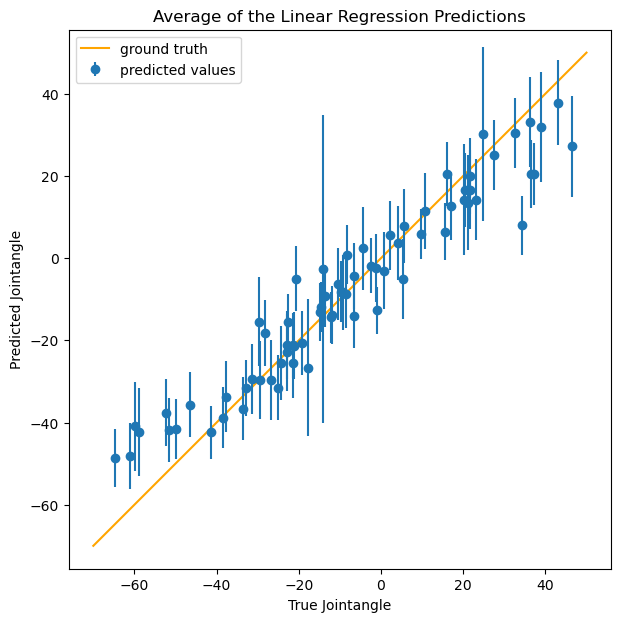

In [21]:
make_errorbar_plot(np.rad2deg(y_test), deg_preds)

In [22]:
split_into

39

In [23]:
outputlength

2048

In [24]:
split_intooutputlength / SR

NameError: name 'split_intooutputlength' is not defined

In [25]:
deg_preds = np.rad2deg(clf.predict(X_test))

(72, 39)
4.992
(39,) (39,) (39,)


[Text(0.5, 0, 'Time [s]'),
 Text(0, 0.5, 'Error [deg]'),
 Text(0.5, 1.0, 'Average Error over Time')]

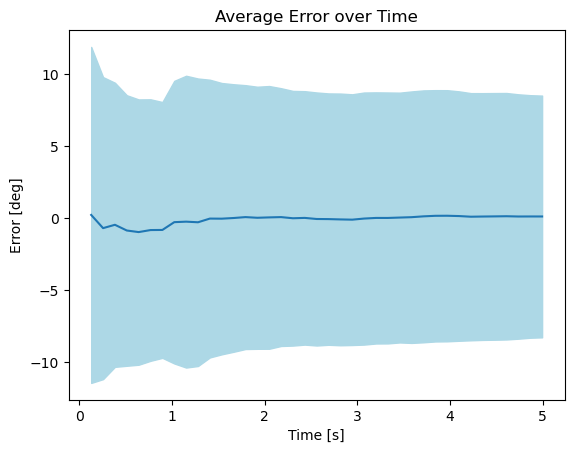

In [26]:
#f, ax = plt.subplots(figsize=(5,3))
cumulative_avg = (np.cumsum((deg_preds - np.rad2deg(y_test)).reshape(-1, split_into), axis=1)/(np.arange(split_into)+1)[None, :])
print(cumulative_avg.shape)
avg_cumsum = np.average(cumulative_avg, axis=0)
std_cumsum = np.std(cumulative_avg, axis=0)
x_time = np.arange(1, split_into+1) * outputlength / SR
print(x_time[-1])
print(x_time.shape, avg_cumsum.shape, std_cumsum.shape)

plt.fill_between(x_time, avg_cumsum-std_cumsum, avg_cumsum+std_cumsum, color="lightblue")
plt.plot(x_time, avg_cumsum)

plt.gca().set(xlabel="Time [s]", ylabel="Error [deg]", title="Average Error over Time")

/home/tilman/miniforge3/envs/acousticSensing/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:557: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/tilman/miniforge3/envs/acousticSensing/lib/python3.12/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


[Text(0.5, 0, 'time [s]')]

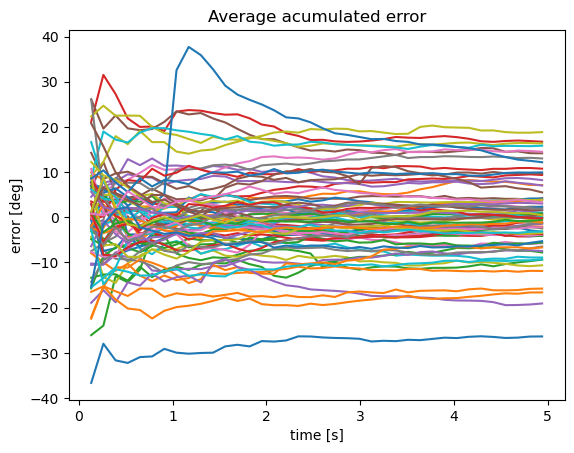

In [27]:
for j in range(len(y_test)//split_into):
    plt.plot(np.arange(split_into) * 0.13, [np.average((deg_preds.reshape(-1, split_into) - np.rad2deg(y_test).reshape(-1, split_into))[j, :i]) for i in range(split_into)])

plt.title("Average acumulated error")
plt.ylabel("error [deg]")
plt.gca().set(xlabel="time [s]")

In [28]:
plt.xlabel

<function matplotlib.pyplot.xlabel(xlabel: 'str', fontdict: 'dict[str, Any] | None' = None, labelpad: 'float | None' = None, *, loc: "Literal['left', 'center', 'right'] | None" = None, **kwargs) -> 'Text'>

[Text(0.5, 0, 'Angle [deg]'), Text(0.5, 1.0, 'Prediction Error')]

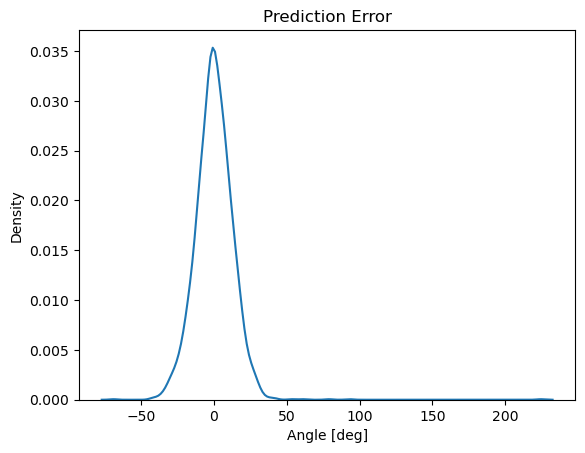

In [29]:
ax = sns.kdeplot(deg_preds - np.rad2deg(y_test))
ax.set(xlabel="Angle [deg]", title="Prediction Error") 

(-50.0, 50.0)

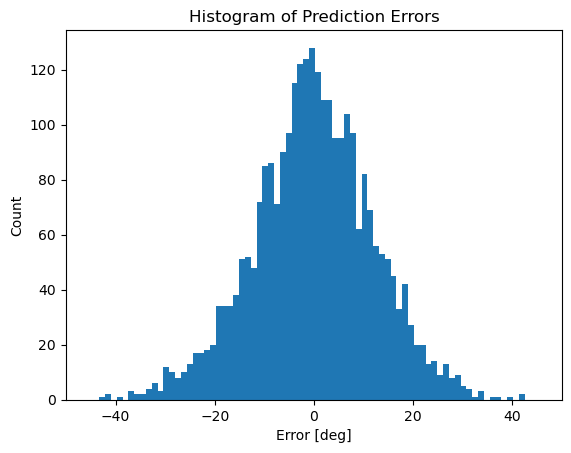

In [30]:
plt.hist(deg_preds - np.rad2deg(y_test), bins=250)
plt.gca().set(xlabel="Error [deg]", ylabel="Count")
plt.title("Histogram of Prediction Errors")
plt.xlim((-50,50))

In [31]:
from sklearn.kernel_ridge import KernelRidge
clf2 = make_pipeline(StandardScaler(), KernelRidge())
clf2.fit(X_train, y_train)
clf2.score(X_train, y_train)

0.8841410534554316

In [32]:
clf2.score(X_test, y_test)

0.757356909044572

In [33]:
print("Linear Regression:")
print(f"MSE: {(np.average(((clf.predict(X_test))-(y_test))**2)):.05f} rad")
print("Kernel Ridge regression:")
print(f"MSE: {(np.average(((clf2.predict(X_test))-(y_test))**2)):.05f} rad")


Linear Regression:
MSE: 0.05247 rad
Kernel Ridge regression:
MSE: 0.05663 rad


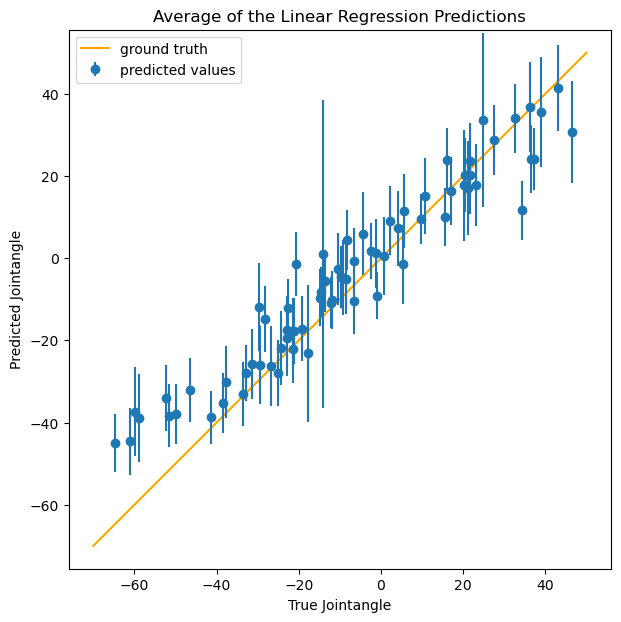

In [34]:
make_errorbar_plot(np.rad2deg(y_test), np.rad2deg(clf2.predict(X_test)))

[1.05534307e-03 1.74420742e-01 1.64023218e-01 1.01796814e-02
 3.05420882e-03 1.13622176e-01 1.08921098e-03 7.39660602e-02
 9.49900963e-02 2.49455193e-02 1.32629693e-03 1.96832341e-03
 5.17973336e-03 1.89784363e-02 1.07520459e-01 8.03551026e-02
 1.01544969e-01 1.23274732e-02 6.20952581e-03 3.18270012e-04
 6.61729509e-04 4.06876283e-04 1.00992590e-03 5.46936095e-05
 8.41208381e-05 6.19135370e-05 3.11584699e-04 2.41466876e-04
 5.15231650e-05 4.13186225e-05]
[0.00796782 0.03263215 0.03211473 0.01531603 0.00901603 0.02738043
 0.03300638 0.01111132 0.06005115 0.00875433 0.02251752 0.04036616
 0.04608404 0.03428758 0.00958124 0.04884202 0.04109199 0.01802602
 0.0635805  0.05497077 0.03538724 0.0528122  0.06155991 0.03868788
 0.06358015 0.02012698 0.04648764 0.02030995 0.03650607 0.00784377]
[0.0391204  0.03920615 0.03916458 0.03920018 0.03913314 0.02656733
 0.02982978 0.03864363 0.02661652 0.03529976 0.03635268 0.03690035
 0.03508402 0.03657453 0.03903984 0.02850842 0.02874204 0.02869675
 0.0

Text(0.5, 0.92, 'Deviation from Average Spectogram')

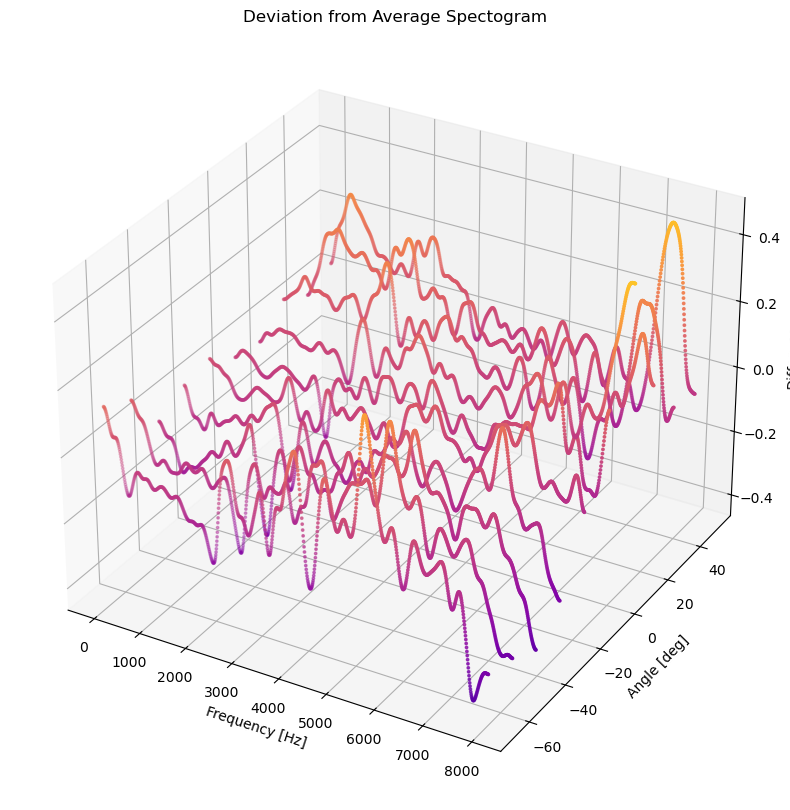

In [ ]:
from scipy.ndimage import gaussian_filter1d

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

avg = np.average(X, axis=0)

# Set up the positions for each histogram
X_averaged = np.average(X.reshape(-1, split_into, X.shape[1]), axis=1)

# Iterate through each histogram's data
angles = np.linspace(np.nanmin(y[:,1]), np.nanmax(y[:,1]), 10)
for i in range(10):
    min_idxs = np.argpartition(np.abs(y[::split_into,1] - angles[i]), 30)[:30]
    #idx = np.nanargmin(np.abs(y[::split_into,1] - angles[i]))
    weights = np.exp(-(y[min_idxs*split_into, 1] - angles[i])**2/0.025)
    weights /= np.sum(weights)
    print(weights)

    nbh_average = np.sum(X_averaged[min_idxs, :] * weights[:, None], axis=0)
    specturm = gaussian_filter1d(np.log(nbh_average)-np.log(avg), 10)
    
    ax.scatter(freq, np.rad2deg(angles[i]), specturm, c=specturm, s=3, vmin=-0.6, vmax=.6, cmap="plasma")#, c=gaussian_filter1d(np.log(X[i, :])-np.log(avg), 7))

# Labels and title
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Angle [deg]')
ax.set_zlabel('Difference')
ax.set_title('Deviation from Average Spectogram')
